# Limpando e concatenando o dataset da INMET

In [ ]:
import pandas as pd
import os
import re

# Definir o diretório onde estão os arquivos CSV
diretorio = '/content/INMET_Sorocaba'

# Lista para armazenar os DataFrames
dataframes = []

# Mapeamento para padronizar os nomes das colunas, dependendo do ano
map_colunas_2006_2018 = {
    'DATA (YYYY-MM-DD)': 'DATA (YYYY-MM-DD)',
    'HORA (UTC)': 'HORA (UTC)',
    'RADIACAO GLOBAL (Kj/m²)': 'RADIACAO GLOBAL (KJ/m²)',
}

map_colunas_2019_2024 = {
    'Data': 'DATA (YYYY-MM-DD)',
    'Hora UTC': 'HORA (UTC)',
    'RADIACAO GLOBAL (Kj/m²)': 'RADIACAO GLOBAL (KJ/m²)',
}

# Função para padronizar o formato da data para 'YYYY-MM-DD'
def padronizar_data(data):
    if isinstance(data, str):  # Verifica se o dado é uma string
        # Tenta converter a data nos dois formatos conhecidos
        for fmt in ['%Y-%m-%d', '%Y/%m/%d']:
            try:
                return pd.to_datetime(data, format=fmt)
            except ValueError:
                continue
        return pd.NaT  # Retorna NaT para valores inválidos
    return pd.NaT  # Retorna NaT para tipos que não são strings

# Função para padronizar o formato da hora
def padronizar_hora(hora):
    if isinstance(hora, str):  # Verifica se o dado é uma string
        if re.match(r'^\d{4} UTC$', hora):  # Exemplo: 1200 UTC
            horas = int(hora[:2])
            minutos = int(hora[2:4])
            return f'{horas:02d}:{minutos:02d}'
        elif re.match(r'^\d{1,2}:\d{2}$', hora):  # Exemplo: 0:00 ou 12:00
            return hora
    return pd.NaT  # Retorna NaT para formatos inválidos

# Função para verificar se a data já está no formato correto
def data_ja_no_formato(data):
    try:
        # Tenta converter a data no formato correto
        pd.to_datetime(data, format='%Y-%m-%d', errors='raise')
        return True
    except:
        return False

# Função para verificar se a hora já está no formato correto
def hora_ja_no_formato(hora):
    return isinstance(hora, str) and re.match(r'^\d{1,2}:\d{2}$', hora)

# Verificar se há arquivos CSV no diretório
csv_files = [f for f in os.listdir(diretorio) if f.endswith('.CSV')]
print(f"Arquivos encontrados: {csv_files}")

# Certifique-se de que existem arquivos para processar
if len(csv_files) == 0:
    print("Nenhum arquivo CSV encontrado no diretório.")
else:
    # Percorrer todos os arquivos CSV no diretório
    for filename in sorted(csv_files):
        filepath = os.path.join(diretorio, filename)
        print(f"Lendo o arquivo: {filename}")  # Debug para ver o arquivo sendo lido
        try:
            # Ler o arquivo CSV com encoding 'latin-1'
            df = pd.read_csv(filepath, encoding='latin-1', sep=';', skiprows=8)
            print(f"Arquivo {filename} lido com sucesso!")  # Debug para confirmar leitura

            # Identificar o formato de colunas e renomeá-las adequadamente
            if 'Data' in df.columns and 'Hora UTC' in df.columns:  # Arquivos 2019-2024
                df.rename(columns=map_colunas_2019_2024, inplace=True)
            else:  # Arquivos 2006-2018
                df.rename(columns=map_colunas_2006_2018, inplace=True)

            # Padronizar as datas e horas
            df['DATA (YYYY-MM-DD)'] = df['DATA (YYYY-MM-DD)'].apply(lambda x: padronizar_data(x) if not data_ja_no_formato(x) else x)
            df['HORA (UTC)'] = df['HORA (UTC)'].apply(lambda x: padronizar_hora(x) if not hora_ja_no_formato(x) else x)

            # Concatenar data e hora em uma nova coluna DataHora
            df['DATAHORA'] = pd.to_datetime(df['DATA (YYYY-MM-DD)'].astype(str) + ' ' + df['HORA (UTC)'].astype(str), errors='coerce')

            # Converter vírgulas em pontos para colunas numéricas
            for col in df.columns:
                if df[col].dtype == 'object':
                    df[col] = df[col].str.replace(',', '.', regex=False)  # Trocar vírgulas por pontos
                    df[col] = pd.to_numeric(df[col], errors='coerce')  # Converter para numérico, se possível

            # Remover a coluna Unnamed: 19 se estiver vazia
            if 'Unnamed: 19' in df.columns:
                df.drop(columns=['Unnamed: 19'], inplace=True)

            # Adicionar DataFrame à lista
            dataframes.append(df)

        except Exception as e:
            print(f"Erro ao processar o arquivo {filename}: {e}")
            continue

    # Concatenar todos os DataFrames em um único DataFrame se houver DataFrames
    if dataframes:
        df_concatenado = pd.concat(dataframes, ignore_index=True)

        # Remover colunas duplicadas, se existirem
        df_concatenado = df_concatenado.loc[:, ~df_concatenado.columns.duplicated()]

        # Exibir as primeiras linhas do DataFrame concatenado
        print("Primeiras linhas do DataFrame concatenado:")
        print(df_concatenado.head())

        # Mostrar informações do DataFrame
        print(f"Formato final: {df_concatenado.shape[0]} rows × {df_concatenado.shape[1]} columns")

        # Opcionalmente, salvar o DataFrame concatenado em um novo arquivo CSV
        df_concatenado.to_csv('dados_concatenados_padronizados.csv', index=False)
    else:
        print("Nenhum DataFrame foi processado com sucesso.")


Arquivos encontrados: ['2012.CSV', '2008.CSV', '2017.CSV', '2009.CSV', '2014.CSV', '2024.CSV', '2010.CSV', '2011.CSV', '2023.CSV', '2022.CSV', '2015.CSV', '2006.CSV', '2013.CSV', '2019.CSV', '2007.CSV', '2021.CSV', '2018.CSV', '2020.CSV', '2016.CSV']
Lendo o arquivo: 2006.CSV
Arquivo 2006.CSV lido com sucesso!
Lendo o arquivo: 2007.CSV
Arquivo 2007.CSV lido com sucesso!
Lendo o arquivo: 2008.CSV
Arquivo 2008.CSV lido com sucesso!
Lendo o arquivo: 2009.CSV
Arquivo 2009.CSV lido com sucesso!
Lendo o arquivo: 2010.CSV
Arquivo 2010.CSV lido com sucesso!
Lendo o arquivo: 2011.CSV
Arquivo 2011.CSV lido com sucesso!
Lendo o arquivo: 2012.CSV
Arquivo 2012.CSV lido com sucesso!
Lendo o arquivo: 2013.CSV
Arquivo 2013.CSV lido com sucesso!
Lendo o arquivo: 2014.CSV
Arquivo 2014.CSV lido com sucesso!
Lendo o arquivo: 2015.CSV
Arquivo 2015.CSV lido com sucesso!
Lendo o arquivo: 2016.CSV
Arquivo 2016.CSV lido com sucesso!
Lendo o arquivo: 2017.CSV
Arquivo 2017.CSV lido com sucesso!
Lendo o arquivo: 

<ipython-input-78-26b5c8b8fb0b>:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concatenado = pd.concat(dataframes, ignore_index=True)


Primeiras linhas do DataFrame concatenado:
  DATA (YYYY-MM-DD)  HORA (UTC)  PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
0               NaT         NaN                               0.0   
1               NaT         NaN                               0.0   
2               NaT         NaN                               0.0   
3               NaT         NaN                               0.0   
4               NaT         NaN                               0.0   

   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
0                                              952.0       
1                                              952.2       
2                                              952.2       
3                                              952.4       
4                                              951.8       

   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
0                                            952.0   
1                                            952.2   
2                  

In [ ]:
df_concatenado

,DATA (YYYY-MM-DD),HORA (UTC),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",DATAHORA
0,NaT,NaN,0.0,952.0,952.0,951.5,-9999.0,9.3,6.2,11.1,9.2,6.7,6.1,81.0,74.0,81.0,164.0,6.0,2.6,2006-08-22 00:00:00
1,NaT,NaN,0.0,952.2,952.2,952.0,-9999.0,8.3,6.0,9.3,8.1,6.4,6.0,87.0,81.0,85.0,163.0,6.9,4.3,2006-08-22 01:00:00
2,NaT,NaN,0.0,952.2,952.3,952.1,-9999.0,7.6,5.5,8.4,7.5,6.0,5.4,87.0,85.0,86.0,176.0,5.6,3.3,2006-08-22 02:00:00
3,NaT,NaN,0.0,952.4,952.4,952.2,-9999.0,7.1,5.1,7.6,7.0,5.4,5.0,88.0,86.0,87.0,169.0,4.5,3.1,2006-08-22 03:00:00
4,NaT,NaN,0.0,951.8,952.4,951.8,-9999.0,6.7,4.8,7.1,6.7,5.1,4.7,88.0,86.0,87.0,167.0,4.0,3.4,2006-08-22 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158035,2024-08-31,NaN,0.0,948.4,948.7,948.4,1846.9,30.8,3.5,31.4,30.4,5.7,2.4,20.0,16.0,18.0,175.0,NaN,NaN,2024-08-31 19:00:00
158036,2024-08-31,NaN,0.0,948.4,948.5,948.4,1054.2,30.2,3.2,31.0,30.0,4.0,1.3,19.0,15.0,18.0,129.0,NaN,NaN,2024-08-31 20:00:00
158037,2024-08-31,NaN,0.0,949.0,949.0,948.4,249.4,25.8,9.1,30.2,25.8,10.2,2.4,35.0,17.0,35.0,176.0,NaN,NaN,2024-08-31 21:00:00
158038,2024-08-31,NaN,0.0,949.3,949.3,949.0,NaN,23.3,9.1,25.9,23.3,9.4,8.9,40.0,35.0,40.0,108.0,NaN,NaN,2024-08-31 22:00:00


## Verificando se os dados tem coerencia

In [ ]:
import pandas as pd
import os

# Definir o diretório onde estão os arquivos CSV
diretorio = '/content/INMET_Sorocaba'

# Dicionário para armazenar a estrutura de cada CSV
estrutura_arquivos = {}

# Percorrer todos os arquivos CSV no diretório
for filename in sorted([f for f in os.listdir(diretorio) if f.endswith('.CSV')]):
    filepath = os.path.join(diretorio, filename)
    try:
        # Lê as primeiras 5 linhas para analisar as colunas
        df = pd.read_csv(filepath, encoding='latin-1', sep=';', skiprows=8, nrows=5)
        colunas = list(df.columns)
        estrutura_arquivos[filename] = colunas
    except Exception as e:
        print(f"Erro ao processar o arquivo {filename}: {e}")
        continue

# Identificar arquivos com estruturas diferentes
estrutura_base = None
diferentes = []

for arquivo, colunas in estrutura_arquivos.items():
    if estrutura_base is None:
        estrutura_base = colunas  # A primeira estrutura é usada como base
        print(f"Estrutura base ({arquivo}): {colunas}\n")  # Exibir a estrutura base
    elif colunas != estrutura_base:
        diferentes.append(arquivo)
        # Mostrar a diferença entre a estrutura atual e a base
        colunas_diferentes = set(colunas).symmetric_difference(set(estrutura_base))
        print(f"{arquivo} tem colunas diferentes: {colunas_diferentes}\n")

# Exibir arquivos que têm estrutura diferente
if diferentes:
    print(f"Os seguintes arquivos têm estruturas diferentes: {diferentes}")
else:
    print("Todos os arquivos têm a mesma estrutura.")


Estrutura base (2006.CSV): ['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', 'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)', 'RADIACAO GLOBAL (KJ/m²)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)', 'TEMPERATURA DO PONTO DE ORVALHO (°C)', 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', 'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)', 'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)', 'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)', 'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)', 'UMIDADE RELATIVA DO AR, HORARIA (%)', 'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)', 'VENTO, VELOCIDADE HORARIA (m/s)', 'Unnamed: 19']

2019.CSV tem colunas diferentes: {'HORA (UTC)', 'Hora UTC', 'DATA (YYYY-MM-DD)', 'Data'}

2020.CSV tem colunas diferentes: {'HORA (UTC)', 'Hora UTC', 'RADIACAO GLOBAL (Kj/m²)', 'DATA

In [ ]:
import os

# Definir o diretório onde estão os arquivos CSV
diretorio = '/content/INMET_Sorocaba'

# Lista para armazenar o tamanho dos arquivos
tamanho_arquivos = {}

# Percorrer todos os arquivos CSV no diretório
for filename in sorted([f for f in os.listdir(diretorio) if f.endswith('.CSV')]):
    filepath = os.path.join(diretorio, filename)
    tamanho = os.path.getsize(filepath)
    tamanho_arquivos[filename] = tamanho

# Exibir arquivos com tamanhos diferentes
for arquivo, tamanho in tamanho_arquivos.items():
    print(f"{arquivo}: {tamanho} bytes")


2006.CSV: 294034 bytes
2007.CSV: 826109 bytes
2008.CSV: 822631 bytes
2009.CSV: 809388 bytes
2010.CSV: 806515 bytes
2011.CSV: 812318 bytes
2012.CSV: 817288 bytes
2013.CSV: 813510 bytes
2014.CSV: 813361 bytes
2015.CSV: 815212 bytes
2016.CSV: 812095 bytes
2017.CSV: 806080 bytes
2018.CSV: 813700 bytes
2019.CSV: 726338 bytes
2020.CSV: 783727 bytes
2021.CSV: 552915 bytes
2022.CSV: 643725 bytes
2023.CSV: 800187 bytes
2024.CSV: 515915 bytes


# Inicio da analize

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the 'latin-1' encoding when reading the CSV file
df = pd.read_csv("/content/dados_concatenados_padronizados.csv", sep=',')

# Exibir primeiras linhas do dataset
df

<ipython-input-191-40097e5a723b>:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/dados_concatenados_padronizados.csv", sep=',')


,DATA (YYYY-MM-DD),HORA (UTC),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",DATAHORA
0,NaN,NaN,0.0,952.0,952.0,951.5,-9999.0,9.3,6.2,11.1,9.2,6.7,6.1,81.0,74.0,81.0,164.0,6.0,2.6,2006-08-22 00:00:00
1,NaN,NaN,0.0,952.2,952.2,952.0,-9999.0,8.3,6.0,9.3,8.1,6.4,6.0,87.0,81.0,85.0,163.0,6.9,4.3,2006-08-22 01:00:00
2,NaN,NaN,0.0,952.2,952.3,952.1,-9999.0,7.6,5.5,8.4,7.5,6.0,5.4,87.0,85.0,86.0,176.0,5.6,3.3,2006-08-22 02:00:00
3,NaN,NaN,0.0,952.4,952.4,952.2,-9999.0,7.1,5.1,7.6,7.0,5.4,5.0,88.0,86.0,87.0,169.0,4.5,3.1,2006-08-22 03:00:00
4,NaN,NaN,0.0,951.8,952.4,951.8,-9999.0,6.7,4.8,7.1,6.7,5.1,4.7,88.0,86.0,87.0,167.0,4.0,3.4,2006-08-22 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158035,2024-08-31,NaN,0.0,948.4,948.7,948.4,1846.9,30.8,3.5,31.4,30.4,5.7,2.4,20.0,16.0,18.0,175.0,NaN,NaN,2024-08-31 19:00:00
158036,2024-08-31,NaN,0.0,948.4,948.5,948.4,1054.2,30.2,3.2,31.0,30.0,4.0,1.3,19.0,15.0,18.0,129.0,NaN,NaN,2024-08-31 20:00:00
158037,2024-08-31,NaN,0.0,949.0,949.0,948.4,249.4,25.8,9.1,30.2,25.8,10.2,2.4,35.0,17.0,35.0,176.0,NaN,NaN,2024-08-31 21:00:00
158038,2024-08-31,NaN,0.0,949.3,949.3,949.0,NaN,23.3,9.1,25.9,23.3,9.4,8.9,40.0,35.0,40.0,108.0,NaN,NaN,2024-08-31 22:00:00


In [ ]:
df = df.drop(columns=['DATA (YYYY-MM-DD)', 'HORA (UTC)'])
df

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",DATAHORA
0,0.0,952.0,952.0,951.5,-9999.0,9.3,6.2,11.1,9.2,6.7,6.1,81.0,74.0,81.0,164.0,6.0,2.6,2006-08-22 00:00:00
1,0.0,952.2,952.2,952.0,-9999.0,8.3,6.0,9.3,8.1,6.4,6.0,87.0,81.0,85.0,163.0,6.9,4.3,2006-08-22 01:00:00
2,0.0,952.2,952.3,952.1,-9999.0,7.6,5.5,8.4,7.5,6.0,5.4,87.0,85.0,86.0,176.0,5.6,3.3,2006-08-22 02:00:00
3,0.0,952.4,952.4,952.2,-9999.0,7.1,5.1,7.6,7.0,5.4,5.0,88.0,86.0,87.0,169.0,4.5,3.1,2006-08-22 03:00:00
4,0.0,951.8,952.4,951.8,-9999.0,6.7,4.8,7.1,6.7,5.1,4.7,88.0,86.0,87.0,167.0,4.0,3.4,2006-08-22 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158035,0.0,948.4,948.7,948.4,1846.9,30.8,3.5,31.4,30.4,5.7,2.4,20.0,16.0,18.0,175.0,NaN,NaN,2024-08-31 19:00:00
158036,0.0,948.4,948.5,948.4,1054.2,30.2,3.2,31.0,30.0,4.0,1.3,19.0,15.0,18.0,129.0,NaN,NaN,2024-08-31 20:00:00
158037,0.0,949.0,949.0,948.4,249.4,25.8,9.1,30.2,25.8,10.2,2.4,35.0,17.0,35.0,176.0,NaN,NaN,2024-08-31 21:00:00
158038,0.0,949.3,949.3,949.0,NaN,23.3,9.1,25.9,23.3,9.4,8.9,40.0,35.0,40.0,108.0,NaN,NaN,2024-08-31 22:00:00


In [ ]:
# Remova a coluna 'DATAHORA' e armazene-a
coluna_datahora = df.pop('DATAHORA')

# Insira a coluna 'DATAHORA' na posição desejada (por exemplo, 1)
df.insert(0, 'DATAHORA', coluna_datahora)

# Exiba o DataFrame resultante
df

,DATAHORA,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
0,2006-08-22 00:00:00,0.0,952.0,952.0,951.5,-9999.0,9.3,6.2,11.1,9.2,6.7,6.1,81.0,74.0,81.0,164.0,6.0,2.6
1,2006-08-22 01:00:00,0.0,952.2,952.2,952.0,-9999.0,8.3,6.0,9.3,8.1,6.4,6.0,87.0,81.0,85.0,163.0,6.9,4.3
2,2006-08-22 02:00:00,0.0,952.2,952.3,952.1,-9999.0,7.6,5.5,8.4,7.5,6.0,5.4,87.0,85.0,86.0,176.0,5.6,3.3
3,2006-08-22 03:00:00,0.0,952.4,952.4,952.2,-9999.0,7.1,5.1,7.6,7.0,5.4,5.0,88.0,86.0,87.0,169.0,4.5,3.1
4,2006-08-22 04:00:00,0.0,951.8,952.4,951.8,-9999.0,6.7,4.8,7.1,6.7,5.1,4.7,88.0,86.0,87.0,167.0,4.0,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158035,2024-08-31 19:00:00,0.0,948.4,948.7,948.4,1846.9,30.8,3.5,31.4,30.4,5.7,2.4,20.0,16.0,18.0,175.0,NaN,NaN
158036,2024-08-31 20:00:00,0.0,948.4,948.5,948.4,1054.2,30.2,3.2,31.0,30.0,4.0,1.3,19.0,15.0,18.0,129.0,NaN,NaN
158037,2024-08-31 21:00:00,0.0,949.0,949.0,948.4,249.4,25.8,9.1,30.2,25.8,10.2,2.4,35.0,17.0,35.0,176.0,NaN,NaN
158038,2024-08-31 22:00:00,0.0,949.3,949.3,949.0,NaN,23.3,9.1,25.9,23.3,9.4,8.9,40.0,35.0,40.0,108.0,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158040 entries, 0 to 158039
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   DATAHORA                                               158040 non-null  object 
 1   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       147549 non-null  float64
 2   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  147964 non-null  float64
 3   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        147731 non-null  float64
 4   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       147731 non-null  float64
 5   RADIACAO GLOBAL (KJ/m²)                                131541 non-null  float64
 6   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           147964 non-null  float64
 7   TEMPERATURA DO PONTO DE ORVALHO (°C)                   147964 non-null  float64
 8   TEMPERATURA MÁXIMA NA HORA ANT. (A

In [ ]:
# Convert object columns to numeric, handling errors by replacing them with NaN
for column in df.columns:
  if df[column].dtype == 'object':
    try:
      df[column] = pd.to_numeric(df[column], errors='coerce')
    except ValueError:
      print(f"Could not convert column '{column}' to numeric.")

# Now, you can replace NaN values with a specific value, like 0 or the mean of the column
# Example: df.fillna(0, inplace=True)

# Display the updated DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158040 entries, 0 to 158039
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   DATAHORA                                               0 non-null       float64
 1   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       147549 non-null  float64
 2   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  147964 non-null  float64
 3   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        147731 non-null  float64
 4   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       147731 non-null  float64
 5   RADIACAO GLOBAL (KJ/m²)                                131541 non-null  float64
 6   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           147964 non-null  float64
 7   TEMPERATURA DO PONTO DE ORVALHO (°C)                   147964 non-null  float64
 8   TEMPERATURA MÁXIMA NA HORA ANT. (A

Index(['DATAHORA', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (KJ/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'eventos'],
      dtype='object')


<ipython-input-197-59ac00db8ca0>:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index, 'eventos'] = row['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']


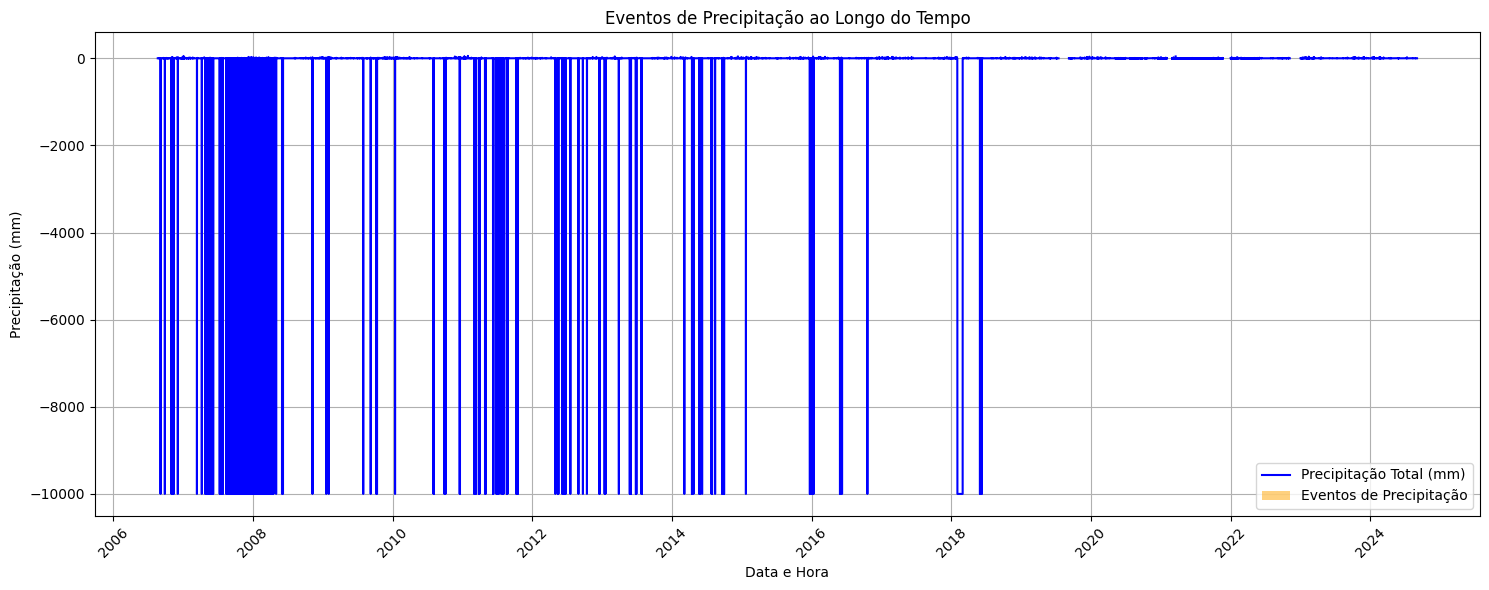

In [ ]:
# Supondo que sua coluna de data/hora se chama 'data_hora' e a de precipitação se chama 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'
# Verifique o nome da sua coluna de data/hora no DataFrame
print(df.columns)

# Se a coluna 'DATAHORA' não existir, substitua 'DATAHORA' pelo nome correto da coluna no seu DataFrame
# Por exemplo, se a coluna se chamar 'DataHora', use:
# df['DataHora'] = pd.to_datetime(df['DataHora'])
df['DATAHORA'] = pd.to_datetime(df['DATAHORA'])  # Certifique-se de que a coluna de data/hora está no formato datetime

# Inicializa a coluna eventos com 0
df['eventos'] = 0

# Loop para identificar eventos de precipitação
for index, row in df.iterrows():
    if row['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 0:
        # Marcando o evento
        df.loc[index, 'eventos'] = row['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']
        # Marcando a janela de 6 horas para frente
        for i in range(1, 7):
            if index + i < len(df):
                df.loc[index + i, 'eventos'] += row['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']
        # Marcando a janela de 6 horas para trás
        for i in range(1, 7):
            if index - i >= 0:
                df.loc[index - i, 'eventos'] += row['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']

df

# Criar a figura e os eixos
plt.figure(figsize=(15, 6))

# Plotar a precipitação
plt.plot(df['DATAHORA'], df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'], label='Precipitação Total (mm)', color='blue')

# Plotar os eventos
plt.bar(df['DATAHORA'], df['eventos'], width=0.03, label='Eventos de Precipitação', color='orange', alpha=0.5)

# Adicionar título e legendas
plt.title('Eventos de Precipitação ao Longo do Tempo')
plt.xlabel('Data e Hora')
plt.ylabel('Precipitação (mm)')
plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
plt.legend()

# Mostrar o gráfico
plt.tight_layout()
plt.grid()
plt.show()


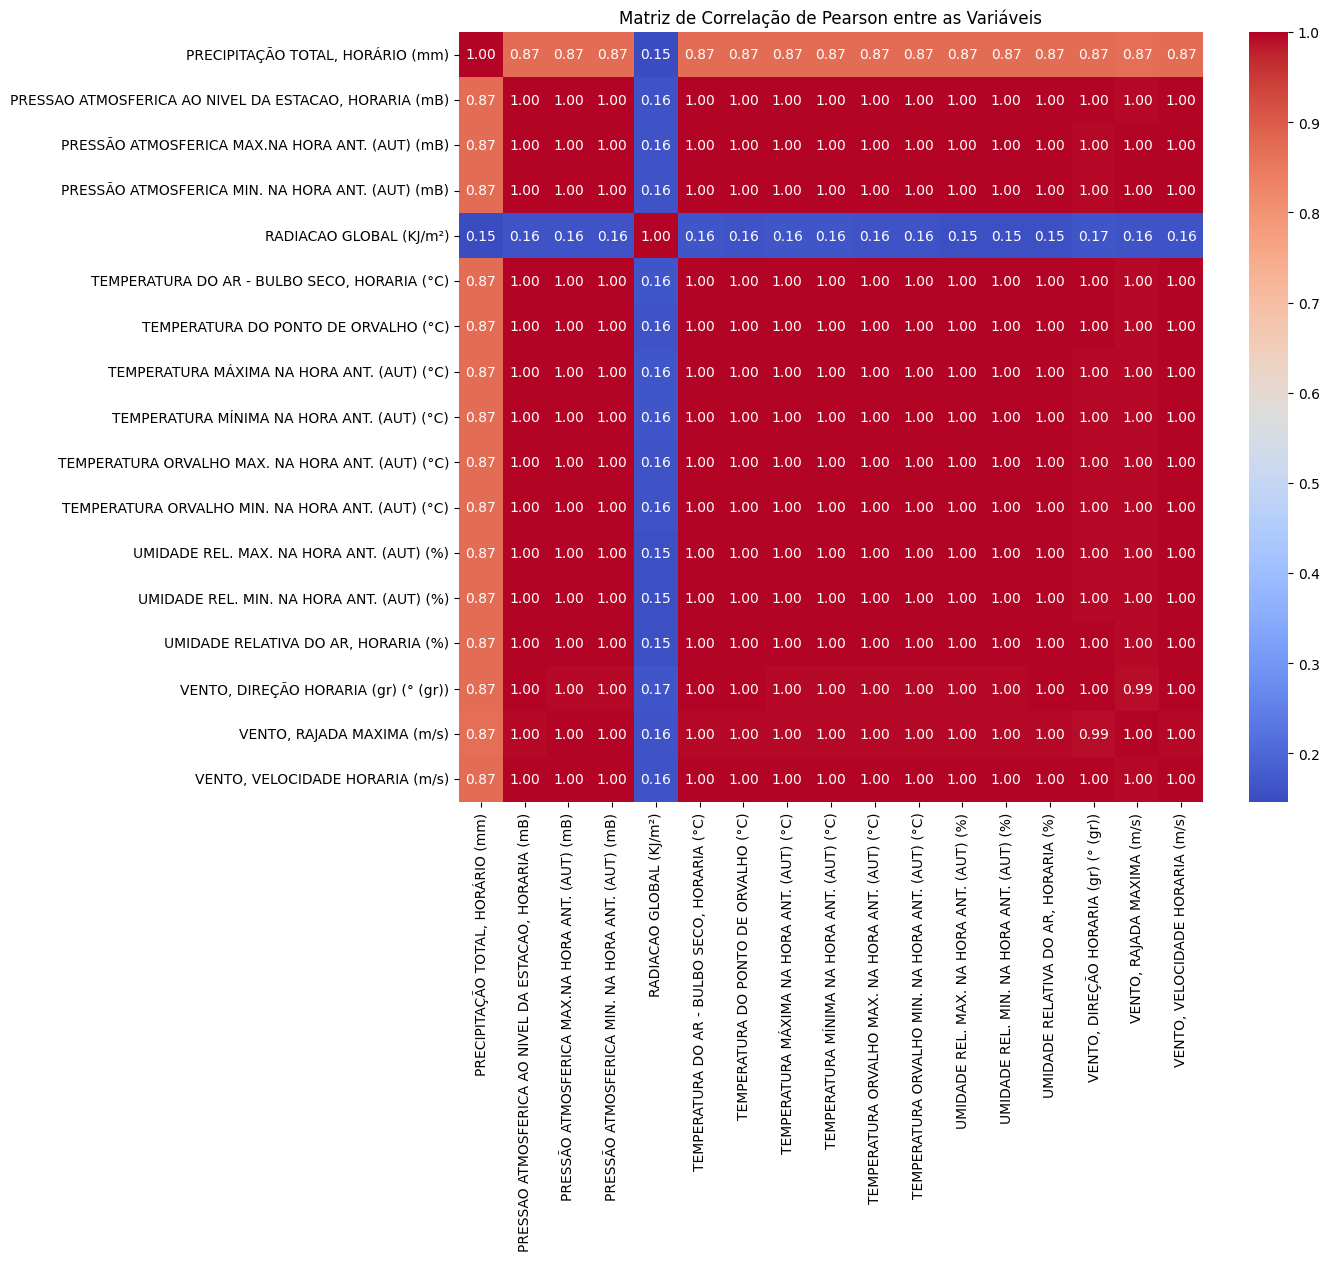

------------------------------------------------------------


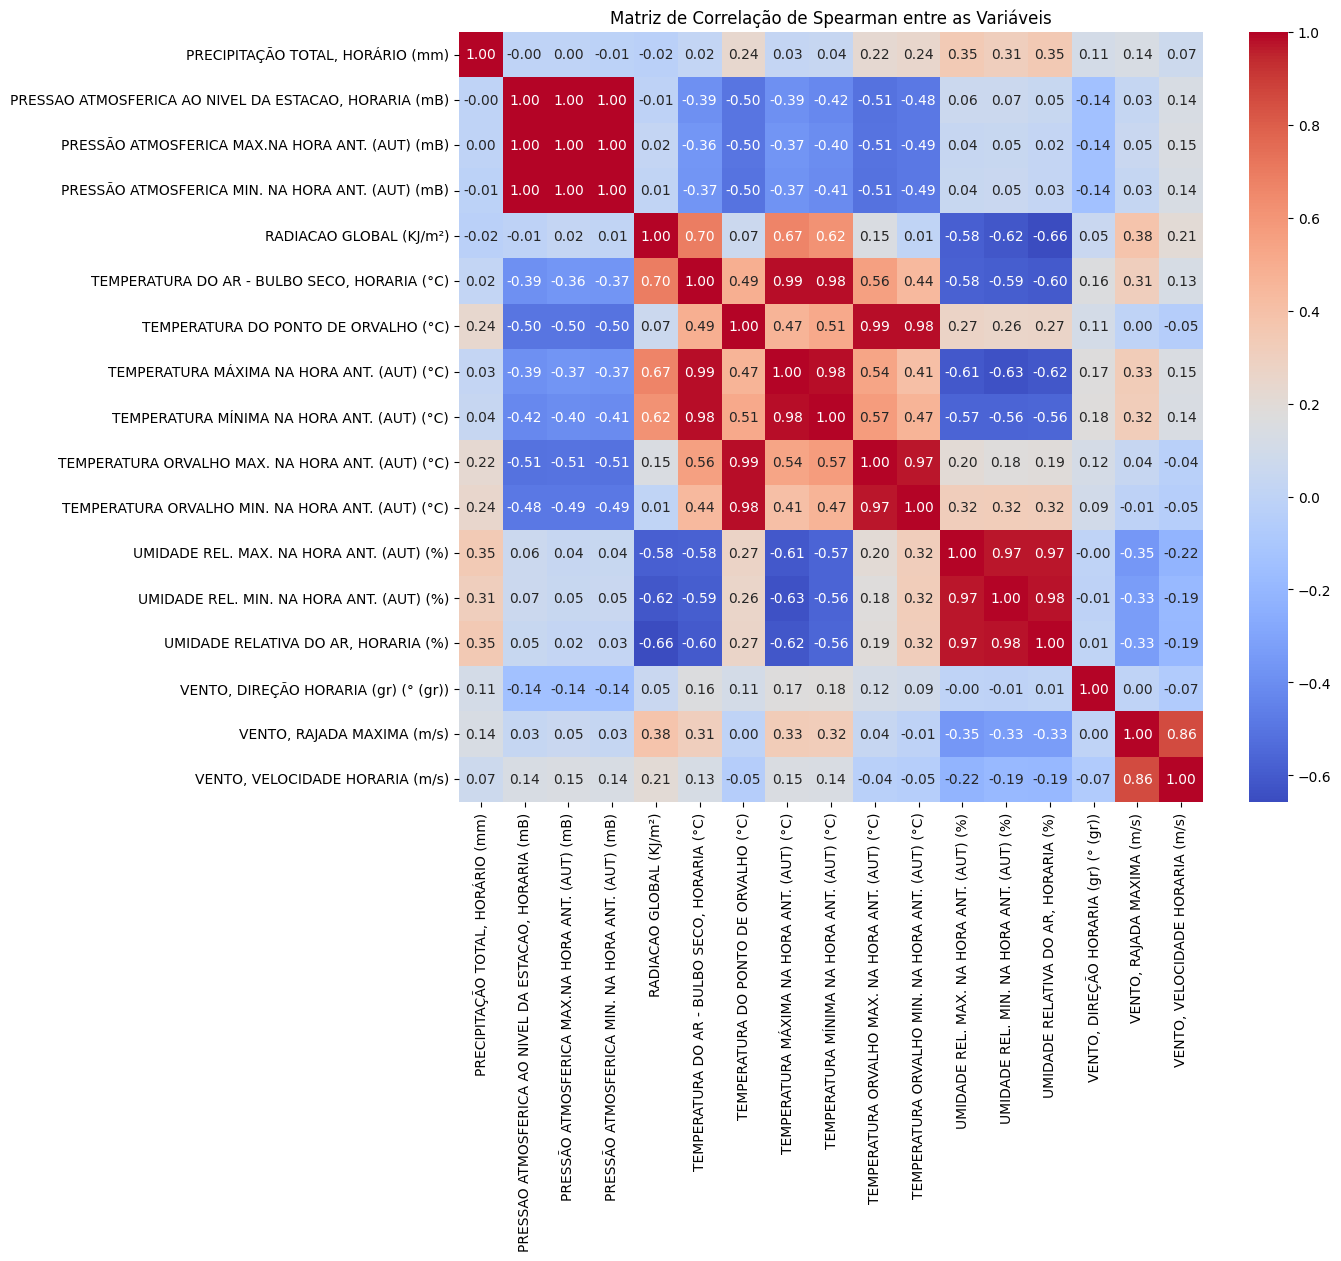

------------------------------------------------------------


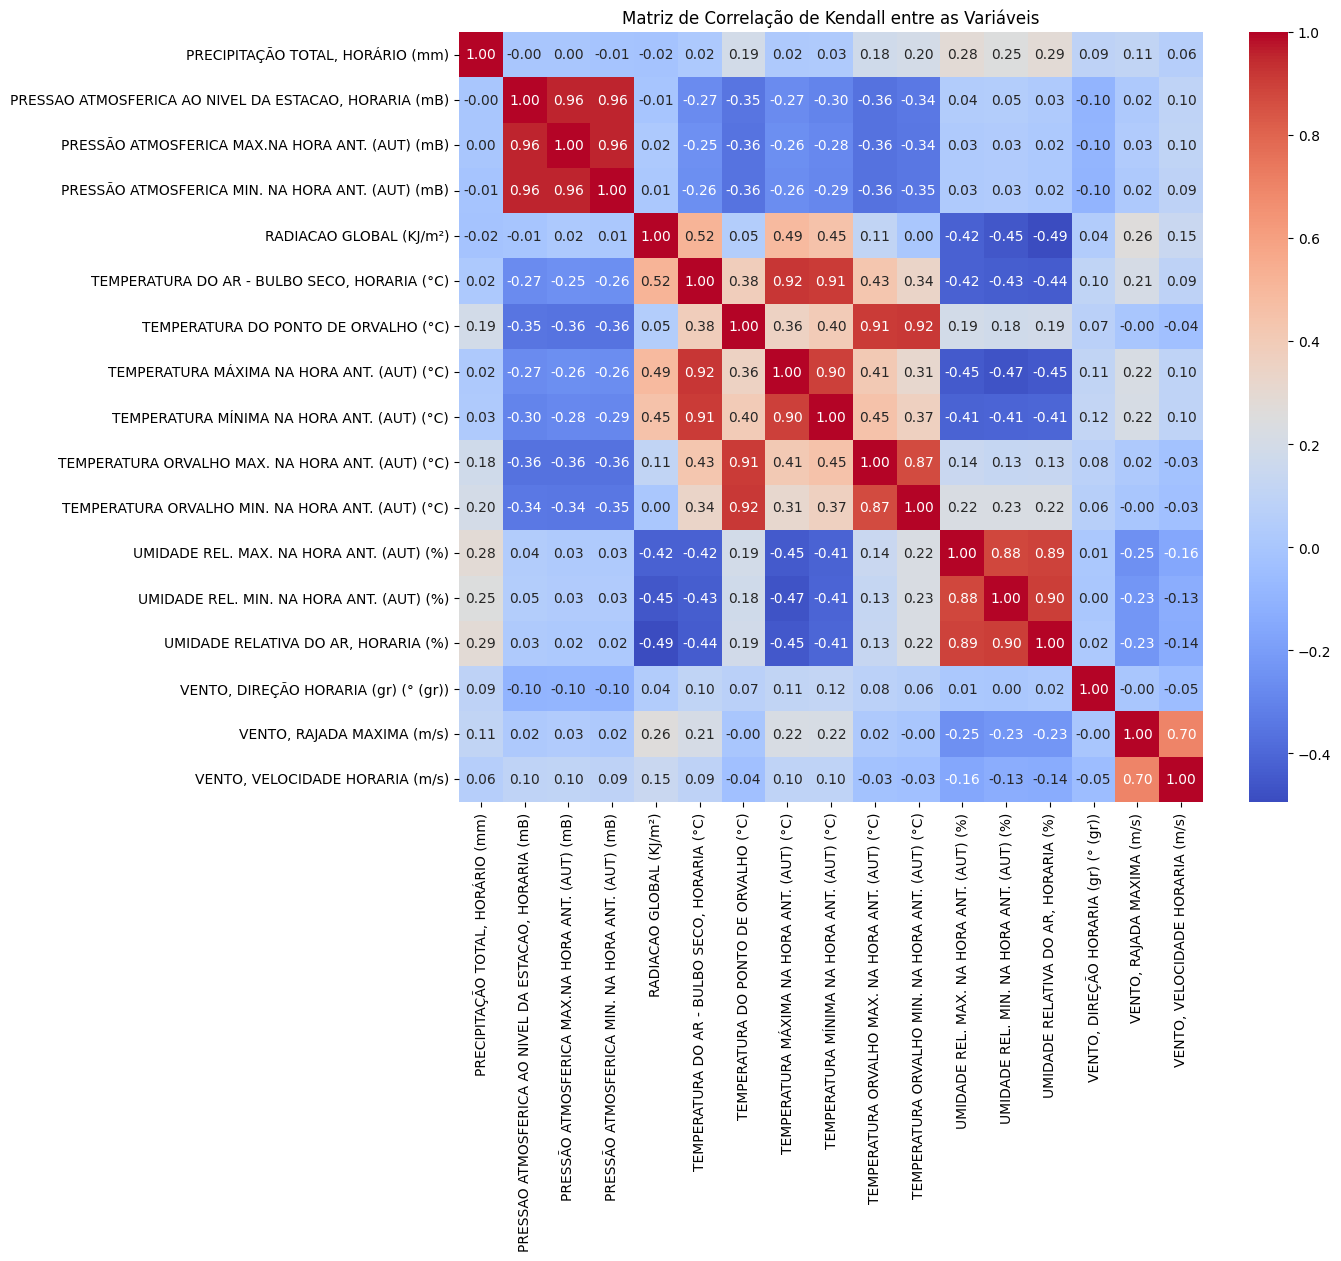

In [ ]:
#aq# Tirar as duas primeiras colunas
df = df.iloc[:, 1:]

# Selecionar colunas numéricas para calcular a correlação
numeric_cols = df.select_dtypes(include=np.number).columns

# 1. Matriz de correlação de Pearson
correlation_matrix = df[numeric_cols].corr()

# Visualizar a matriz de correlação (Pearson)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação de Pearson entre as Variáveis")
plt.show()

print("------------------------------------------------------------")

# 2. Matriz de correlação de Spearman
spearman_correlation = df[numeric_cols].corr(method='spearman')

# Visualizar a matriz de correlação (Spearman)
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação de Spearman entre as Variáveis")
plt.show()

print("------------------------------------------------------------")

# 3. Matriz de correlação de Kendall
kendall_correlation = df[numeric_cols].corr(method='kendall')

# Visualizar a matriz de correlação (Kendall)
plt.figure(figsize=(12, 10))
sns.heatmap(kendall_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação de Kendall entre as Variáveis")
plt.show()

In [ ]:
# Filtrar eventos de chuva intensos
# Filtrando para acumulados superiores a 10 mm e 20 mm
filtro_10mm = df[df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 10]
filtro_20mm = df[df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 20]

# Exibir o número de eventos filtrados
print(f"Número de eventos com mais de 10 mm: {len(filtro_10mm)}")
print(f"Número de eventos com mais de 20 mm: {len(filtro_20mm)}")

# Se precisar calcular a média das variáveis para os eventos filtrados
media_variaveis_10mm = filtro_10mm.mean()  # Calcular média para eventos > 10 mm
media_variaveis_20mm = filtro_20mm.mean()  # Calcular média para eventos > 20 mm

# Exibir as médias
print("Média das variáveis para eventos > 10 mm:")
print(media_variaveis_10mm)

print("Média das variáveis para eventos > 20 mm:")
print(media_variaveis_20mm)

Número de eventos com mais de 10 mm: 365
Número de eventos com mais de 20 mm: 104
Média das variáveis para eventos > 10 mm:
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                           17.829041
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)     943.955890
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)           944.466301
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)          943.065205
RADIACAO GLOBAL (KJ/m²)                                 -2190.621818
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)               20.003562
TEMPERATURA DO PONTO DE ORVALHO (°C)                       19.047945
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                 22.654247
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                 19.474795
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)           19.853425
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)           18.220822
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                   95.134247
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)        

Eventos > 10 mm:

Precipitação Total: 17.83 mm (média), indicando que esses eventos têm uma intensidade de chuva considerável.
Umidade Relativa: Altas taxas de umidade (cerca de 94.29% e até 95.13% na umidade máxima) são observadas, o que é esperado durante chuvas intensas.
Temperatura do Ar: Média de aproximadamente 20 °C, sugerindo que esses eventos de chuva ocorrem em temperaturas amenas.
Vento: Velocidade média de vento de cerca de 2.78 m/s, o que não indica ventos fortes associados a esses eventos.

Eventos > 20 mm:

Precipitação Total: 27.47 mm (média), mostrando que esses eventos são ainda mais intensos em comparação aos eventos de mais de 10 mm.
Umidade Relativa: Uma leve elevação na umidade máxima (95.68%) e na umidade mínima (81.84%) em comparação aos eventos de 10 mm, indicando que a umidade é um fator relevante para chuvas mais intensas.
Temperatura do Ar: A temperatura média permanece similar (20.03 °C), sugerindo que a condição térmica não varia muito entre os dois tipos de eventos.
Vento: A velocidade do vento média é um pouco mais alta (2.80 m/s), mas ainda assim não é um indicativo de tempestades severas.

Matriz de correlação:
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                         1.000000
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)   -0.031460
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)         -0.032569
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)        -0.069735
RADIACAO GLOBAL (KJ/m²)                                  0.118562
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)             0.016237
TEMPERATURA DO PONTO DE ORVALHO (°C)                     0.102706
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               0.083454
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               0.031336
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         0.136523
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)         0.083806
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                 0.223438
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                -0.015032
UMIDADE RELATIVA DO AR, HORARIA (%)                      0.202290
VENTO, DIREÇÃO HORARIA (gr) (° (gr))                  

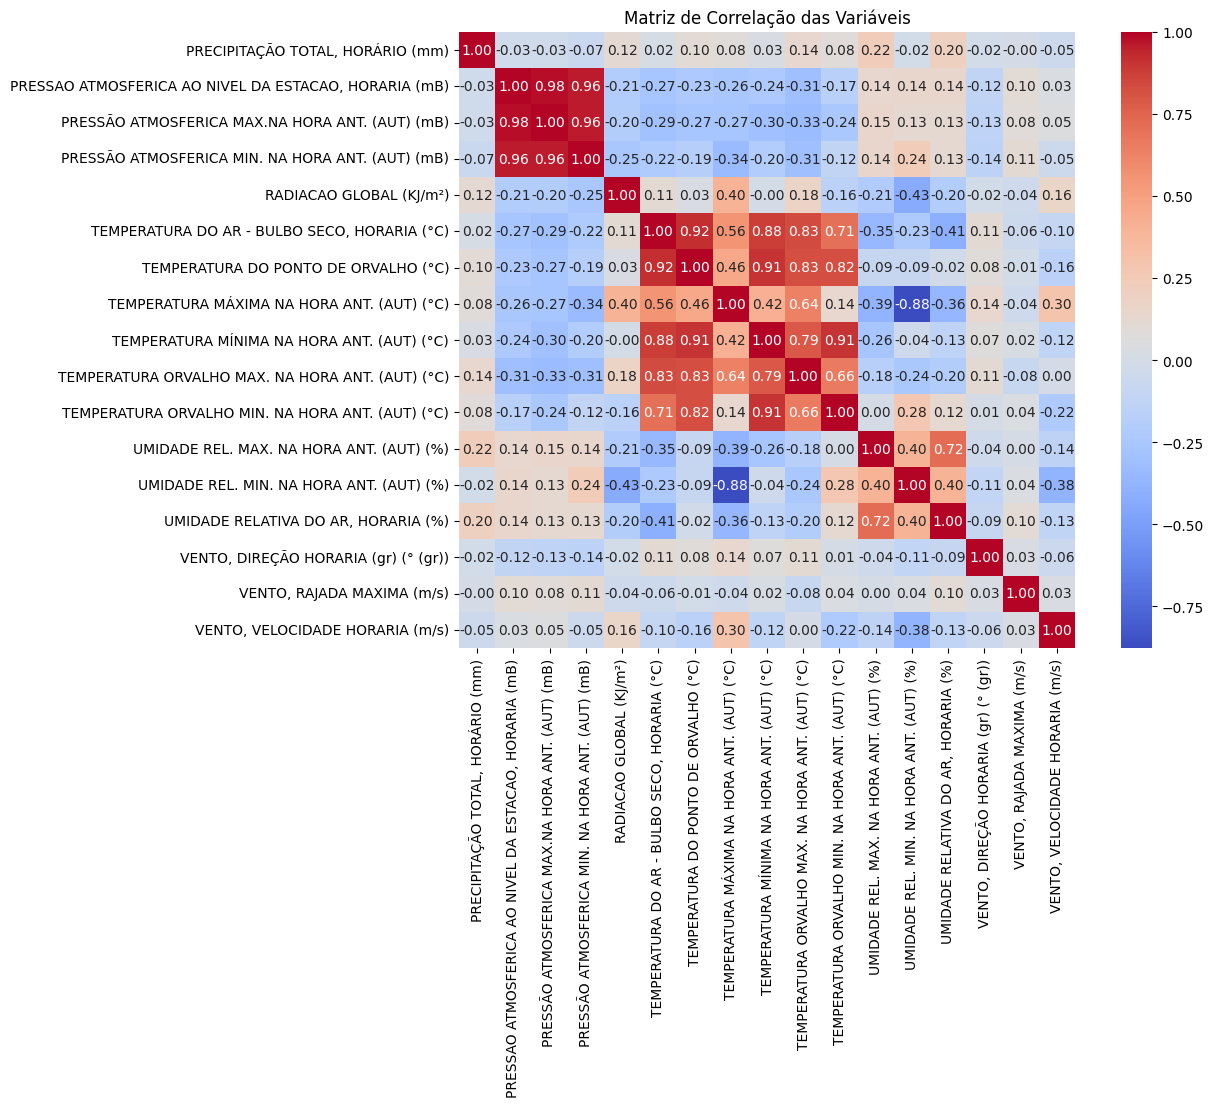

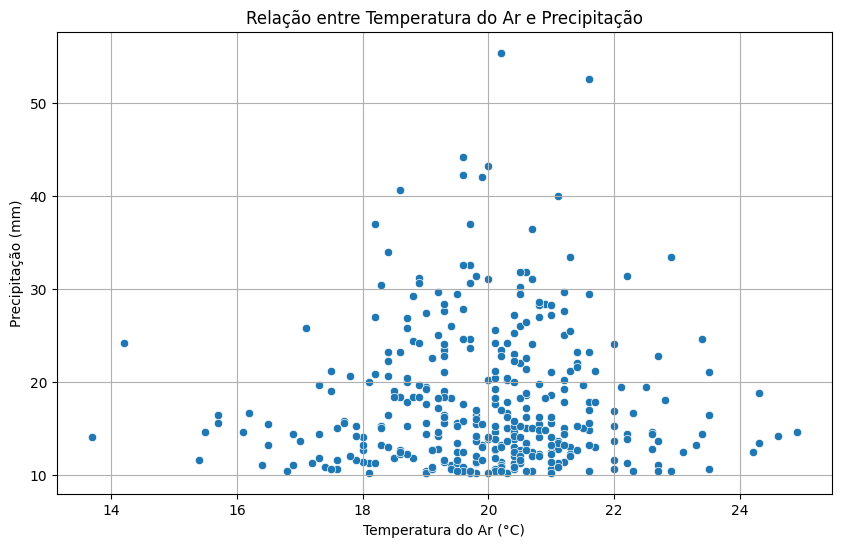

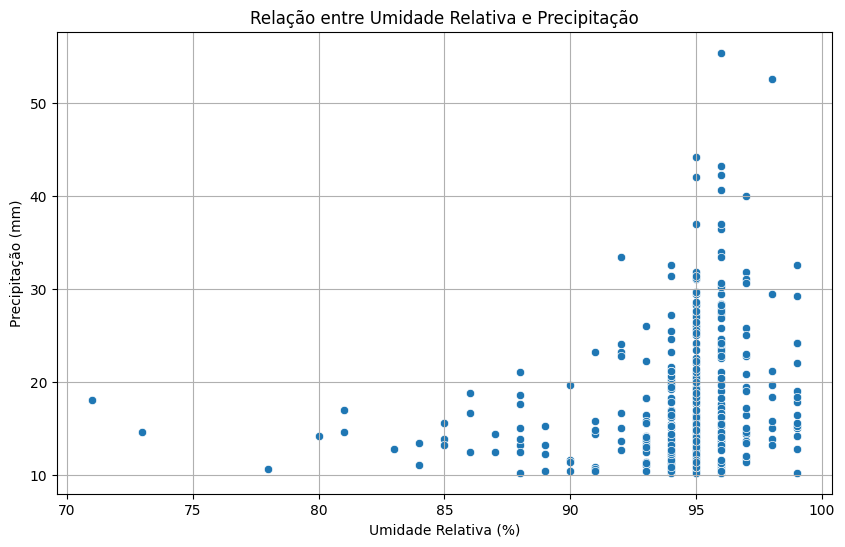

In [ ]:
import seaborn as sns

# Filtrar para eventos > 10 mm
filtro_10mm = df[df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 10]

# Calcular a correlação
correlacao = filtro_10mm.corr()

# Exibir a matriz de correlação
print("Matriz de correlação:")
print(correlacao['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'])

# Criar um heatmap para visualizar a correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de Correlação das Variáveis')
plt.show()

plt.figure(figsize=(10, 6))
# Substitua 'TEMPERATURA DO AR - BULBO SECO, HORARIO (°C)'
# pelo nome correto da coluna de temperatura
sns.scatterplot(x=filtro_10mm['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'],
                y=filtro_10mm['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'])
plt.title('Relação entre Temperatura do Ar e Precipitação')
plt.xlabel('Temperatura do Ar (°C)')
plt.ylabel('Precipitação (mm)')
plt.grid()
plt.show()

# Outro exemplo: precipitação vs umidade relativa
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtro_10mm['UMIDADE RELATIVA DO AR, HORARIA (%)'],
                y=filtro_10mm['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'])
plt.title('Relação entre Umidade Relativa e Precipitação')
plt.xlabel('Umidade Relativa (%)')
plt.ylabel('Precipitação (mm)')
plt.grid()
plt.show()


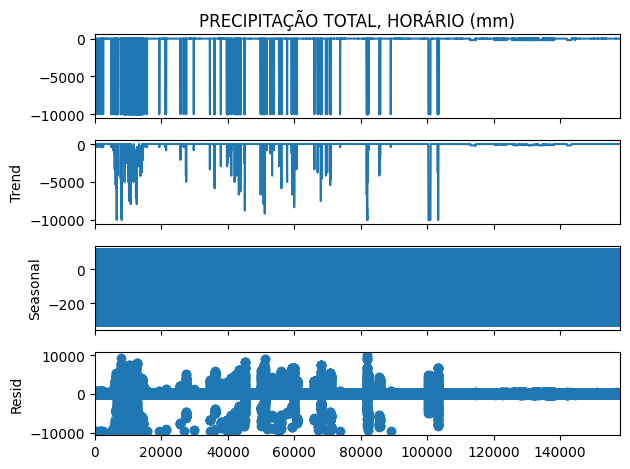

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

target_column = 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'

df[target_column] = df[target_column].fillna(df[target_column].mean())

result = seasonal_decompose(df[target_column], model='additive', period=24)
result.plot()
plt.show()

<Figure size 1000x600 with 0 Axes>

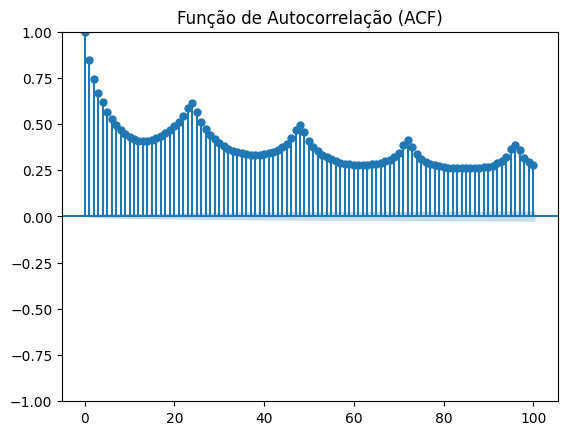

<Figure size 1000x600 with 0 Axes>

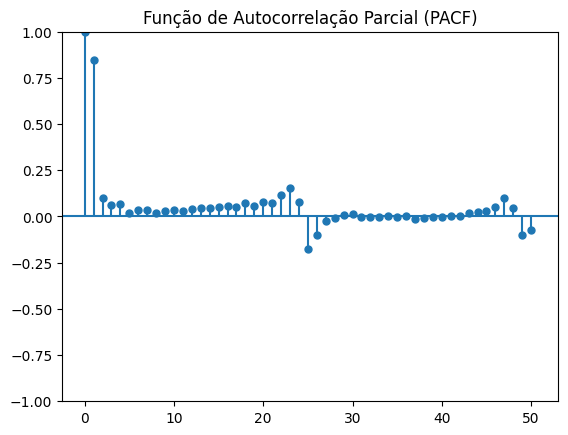

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Exibir o gráfico de ACF
plt.figure(figsize=(10, 6))
plot_acf(df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'], lags=100)
plt.title("Função de Autocorrelação (ACF)")
plt.show()

# Exibir o gráfico de PACF
plt.figure(figsize=(10, 6))
plot_pacf(df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'], lags=50)
plt.title("Função de Autocorrelação Parcial (PACF)")
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

# Função para criar as janelas de tempo (input e output para o modelo)
def create_dataset(series, time_step):
    X, y = [], []
    for i in range(len(series) - time_step):
        # Use .iloc for integer-location based indexing
        X.append(series.iloc[i:(i + time_step), 0].values)
        y.append(series.iloc[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 1  # Número de dias usados para prever o próximo valor
X, y = create_dataset(df[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']], time_step)


# Redimensionar os dados para o formato [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir dados em treino e teste (80% treino, 20% teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Função para construir o modelo LSTM ou GRU
def build_rnn_model(model_type='LSTM'):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=False, input_shape=(time_step, 1)))
    model.add(Dense(1))  # Saída com 1 valor predito
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Perda no teste (LSTM): 1979.5845947265625
Perda no teste (GRU): 2299.48486328125
988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


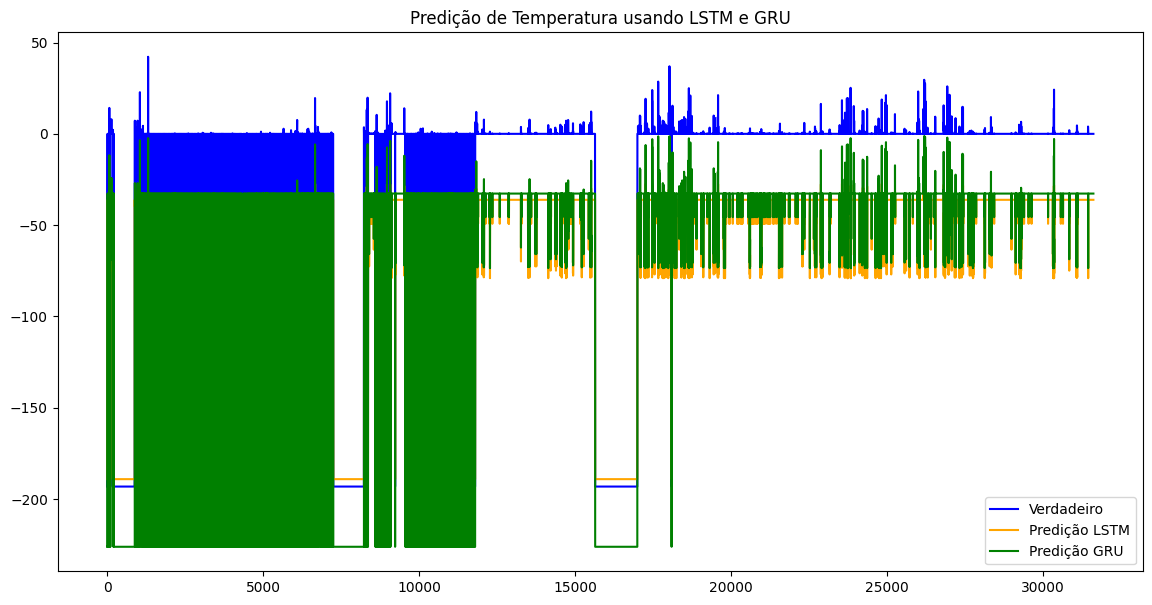

In [ ]:
# Construir e treinar o modelo LSTM
model_lstm = build_rnn_model(model_type='LSTM')
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Construir e treinar o modelo GRU
model_gru = build_rnn_model(model_type='GRU')
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Avaliar os modelos
loss_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
loss_gru = model_gru.evaluate(X_test, y_test, verbose=0)

print(f"Perda no teste (LSTM): {loss_lstm}")
print(f"Perda no teste (GRU): {loss_gru}")

# Fazer predições
y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)

# Visualizar as predições
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Verdadeiro', color='blue')
plt.plot(y_pred_lstm, label='Predição LSTM', color='orange')
plt.plot(y_pred_gru, label='Predição GRU', color='green')
plt.title('Predição de Temperatura usando LSTM e GRU')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.0347 - val_loss: 0.0203
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0287 - val_loss: 0.0195
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0283 - val_loss: 0.0195
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0256 - val_loss: 0.0197
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0341 - val_loss: 0.0200
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0296 - val_loss: 0.0195
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0280 - val_loss: 0.0197
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0299 - val_loss: 0.0199
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0277 - val_loss: 0.0197
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0281 - val_loss: 0.0196
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0285 - val_loss: 0.0198
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0292 - val_loss: 0.0201


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


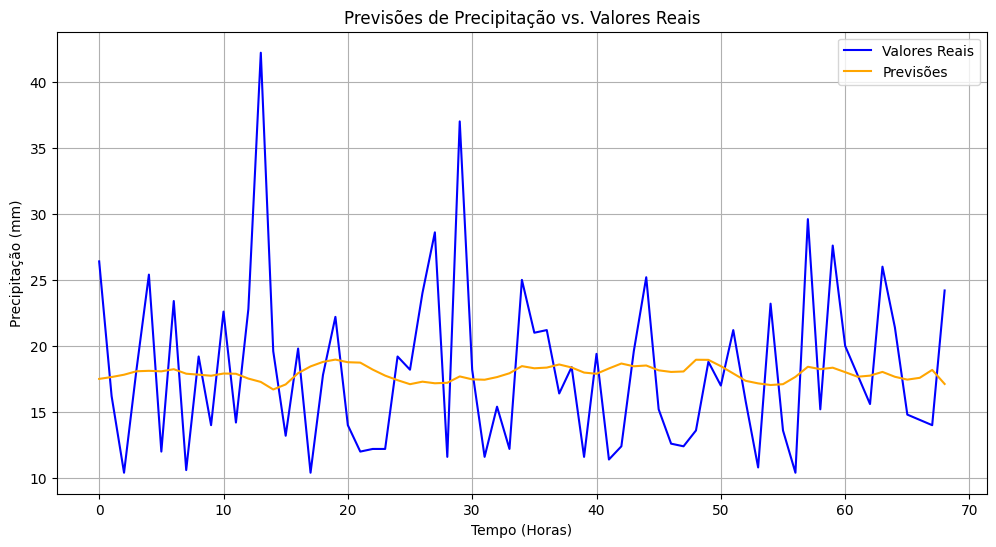

In [ ]:
# Filtrar apenas eventos de > 10 mm
filtro_10mm = df[df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 10]

# Selecionar as variáveis relevantes para o modelo
variaveis_relevantes = filtro_10mm[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)', 'UMIDADE RELATIVA DO AR, HORARIA (%)']]
variaveis_relevantes = variaveis_relevantes.fillna(0)  # Substituindo NaN por 0 (ou outra estratégia de tratamento)

# Escalonar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
dados_escalonados = scaler.fit_transform(variaveis_relevantes)

# Criar sequências de dados para o modelo LSTM
def criar_sequencias(data, passos):
    X, y = [], []
    for i in range(len(data) - passos):
        X.append(data[i:i + passos])
        y.append(data[i + passos, 0])  # Previsão da precipitação
    return np.array(X), np.array(y)

passos = 24  # Por exemplo, usar as últimas 24 horas para prever a próxima hora
X, y = criar_sequencias(dados_escalonados, passos)

# Dividir em conjuntos de treinamento e validação
tamanho_treino = int(len(X) * 0.8)
X_treino, X_val = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_val = y[:tamanho_treino], y[tamanho_treino:]

# Definir o modelo LSTM
modelo = Sequential()
modelo.add(LSTM(50, return_sequences=True, input_shape=(X_treino.shape[1], X_treino.shape[2])))
modelo.add(Dropout(0.2))
modelo.add(LSTM(50))
modelo.add(Dropout(0.2))
modelo.add(Dense(1))  # Saída única

modelo.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
modelo.fit(X_treino, y_treino, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Treinar o modelo
historico = modelo.fit(X_treino, y_treino, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Fazer previsões
previsoes = modelo.predict(X_val)

# Inverter a escala para comparar com os valores reais
previsoes_invertidas = scaler.inverse_transform(np.concatenate((previsoes, np.zeros((previsoes.shape[0], 2))), axis=1))[:, 0]
y_val_invertidos = scaler.inverse_transform(np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], 2))), axis=1))[:, 0]

# Plotar as previsões contra os valores reais
plt.figure(figsize=(12, 6))
plt.plot(y_val_invertidos, label='Valores Reais', color='blue')
plt.plot(previsoes_invertidas, label='Previsões', color='orange')
plt.title('Previsões de Precipitação vs. Valores Reais')
plt.xlabel('Tempo (Horas)')
plt.ylabel('Precipitação (mm)')
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Perda no teste (LSTM): 1883.945068359375
Perda no teste (GRU): 2140.990234375
988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
988/988 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


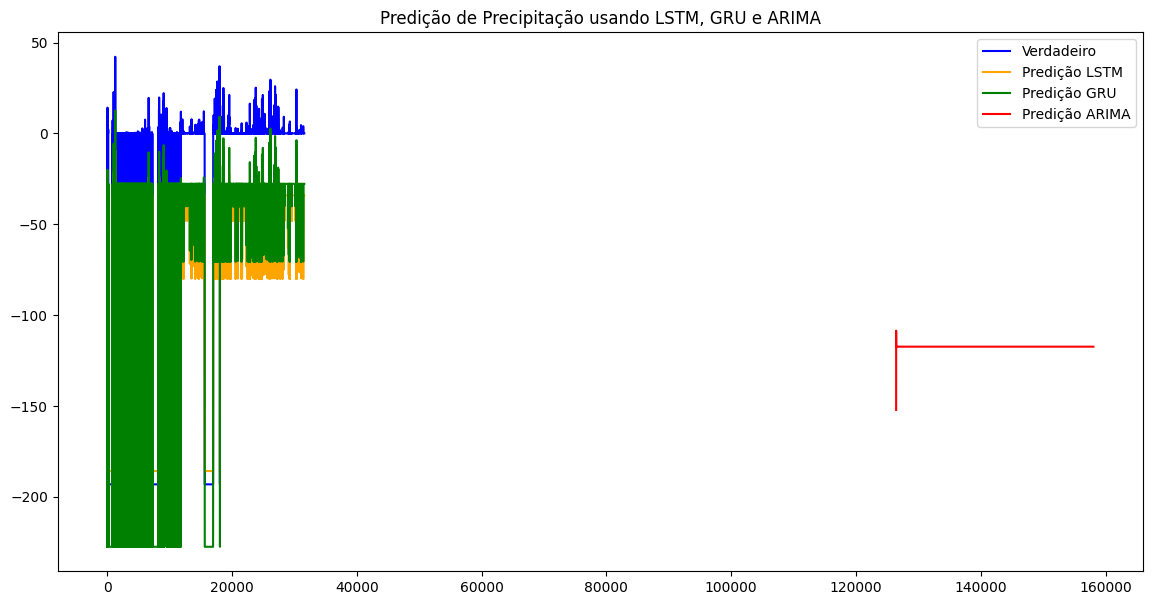

Erro médio quadrático (ARIMA): 11724.614490877522


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Carregar os dados (supondo que 'df' já está definido com os dados)
# df = pd.read_csv('seus_dados.csv')  # Descomente e ajuste se necessário

# Função para criar as janelas de tempo (input e output para o modelo)
def create_dataset(series, time_step):
    X, y = [], []
    for i in range(len(series) - time_step):
        X.append(series.iloc[i:(i + time_step), 0].values)
        y.append(series.iloc[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 1  # Número de dias usados para prever o próximo valor
X, y = create_dataset(df[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']], time_step)

# Redimensionar os dados para o formato [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir dados em treino e teste (80% treino, 20% teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Função para construir o modelo LSTM ou GRU
def build_rnn_model(model_type='LSTM'):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=False, input_shape=(time_step, 1)))
    model.add(Dense(1))  # Saída com 1 valor predito
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Construir e treinar o modelo LSTM
model_lstm = build_rnn_model(model_type='LSTM')
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Construir e treinar o modelo GRU
model_gru = build_rnn_model(model_type='GRU')
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Avaliar os modelos
loss_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
loss_gru = model_gru.evaluate(X_test, y_test, verbose=0)

print(f"Perda no teste (LSTM): {loss_lstm}")
print(f"Perda no teste (GRU): {loss_gru}")

# Fazer predições
y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)

# Para o modelo ARIMA
# A série deve ser unidimensional e sem valores NaN
serie_arima = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].dropna()

# Dividir a série em treino e teste
train_arima = serie_arima[:train_size]
test_arima = serie_arima[train_size:]

# Ajustar o modelo ARIMA
model_arima = ARIMA(train_arima, order=(5, 1, 0))  # Ajustar os parâmetros conforme necessário
model_arima_fit = model_arima.fit()

# Fazer previsões
y_pred_arima = model_arima_fit.forecast(steps=len(test_arima))

# Visualizar as predições
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Verdadeiro', color='blue')
plt.plot(y_pred_lstm, label='Predição LSTM', color='orange')
plt.plot(y_pred_gru, label='Predição GRU', color='green')
plt.plot(y_pred_arima, label='Predição ARIMA', color='red')
plt.title('Predição de Precipitação usando LSTM, GRU e ARIMA')
plt.legend()
plt.show()

# Avaliar a performance do ARIMA
mse_arima = mean_squared_error(test_arima, y_pred_arima)
print(f"Erro médio quadrático (ARIMA): {mse_arima}")
